# Mechanism Prediction

This notebook shows the approximate reaction mechanisms extracted on a few examples of the validation dataset.
It also shows the predictions made by the ELECTRO-LITE model.
The mechanisms are drawn as arrow-pushing diagrams with code provided to do this using rdkit.

Please note that the arrow-pushing diagram code cannot deal with edge cases, eg loops etc. But is hopefully useful as a rough aid for interrogating the model.

## Defining functions which draw the arrow-pushing diagrams.

In [1]:
# Misc module imports

import typing
import itertools

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.six import iteritems

import numpy as np

from matplotlib import pyplot as plt
import matplotlib.patches as patches



In [2]:
# Molecule drawing plot

def new_init(self, size, name='', imageType='png', fig=None, ax=None):
    self._name = name
    self.size = size
    dpi = max(size[0], size[1])
    figsize = (int(float(size[0]) / dpi), int(float(size[1]) / dpi))
    if fig is None or ax is None:
        print("Creating new axis")
        self._figure = figure(figsize=figsize)
        self._axes = self._figure.add_axes([0, 0, 2.5, 2.5])
    else:
        self._figure = fig
        self._axes = ax
    self._axes.set_xticklabels('')
    self._axes.set_yticklabels('')
    self._dpi = dpi

from rdkit.Chem.Draw.mplCanvas import Canvas
Canvas.__init__ = new_init

    
def MolToMPL(mol, size=(300, 300), kekulize=True, wedgeBonds=True, imageType=None, fitImage=False,
             options=None, fig=None, ax=None, **kwargs):
    """
    Generates a drawing of a molecule on a matplotlib canvas

    Small modification of the version in rdkit main so that it returns the drawer and mol after.
    
    The rdkit version can be found @:
    https://github.com/rdkit/rdkit/blob/00cb303096c9a35ae5c76275914972382c2f39c1/rdkit/Chem/Draw/__init__.py
    
    Rdkit licence is:
    Unless otherwise noted, all files in this directory and all
    subdirectories are distributed under the following license:

    Copyright (c) 2006-2015
    Rational Discovery LLC, Greg Landrum, and Julie Penzotti 

    All rights reserved.

    Redistribution and use in source and binary forms, with or without
    modification, are permitted provided that the following conditions are
    met: 

        * Redistributions of source code must retain the above copyright 
          notice, this list of conditions and the following disclaimer.
        * Redistributions in binary form must reproduce the above
          copyright notice, this list of conditions and the following 
          disclaimer in the documentation and/or other materials provided 
          with the distribution.
        * Neither the name of Rational Discovery nor the names of its 
          contributors may be used to endorse or promote products derived 
          from this software without specific prior written permission.

    THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
    "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
    LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
    A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
    OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
    SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
    LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
    DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
    THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
    (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
    OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE
    
    """
    if not mol:
        raise ValueError('Null molecule provided')
    from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
    
    
    
    canvas = Canvas(size, fig=fig, ax=ax)

    
    if options is None:
        options = DrawingOptions()
        options.bgColor = None
    if fitImage:
        options.dotsPerAngstrom = int(min(size) / 10)
    options.wedgeDashedBonds = wedgeBonds
    options.atomLabelFontSize = 8
    drawer = MolDrawing(canvas=canvas, drawingOptions=options)
    omol = mol
    if kekulize:
        from rdkit import Chem
        mol = Chem.Mol(mol.ToBinary())
        Chem.Kekulize(mol)

    if not mol.GetNumConformers():
        from rdkit.Chem import AllChem
        AllChem.Compute2DCoords(mol)

    drawer.AddMol(mol, **kwargs)
    omol._atomPs = drawer.atomPs[mol]
    for k, v in iteritems(omol._atomPs):
        omol._atomPs[k] = canvas.rescalePt(v)
    return canvas._figure, drawer, mol

In [3]:
# Arrow-pushing code.
ARROW_OPTIONS = dict(arrowstyle = "Simple,tail_width=1.0,head_width=8,head_length=8",
                     connectionstyle = "arc3,rad=.5", color = '#FF1493', lw = 2)


def draw_arrow_pushin(molecule_in: Chem.Mol, product_mol: Chem.Mol,
                      actions_am: typing.List[int],  fig=None, ax=None, **kwargs):
    # In this function we only want the new atoms we go to, not the self-bond removal
    # at start if exists.
    if actions_am[0] == actions_am[1]:
        actions_am = actions_am[1:]
    
    # Set up the figure.
    fig, drawer, mol = MolToMPL(molecule_in, fig=fig, ax=ax, **kwargs)
    ax = fig.axes[0] if ax is None else ax

    # Get teh atom map to index mappings 
    atom_mapping_to_idx = {atom.GetPropsAsDict()['molAtomMapNumber']: idx
                           for idx, atom in enumerate(mol.GetAtoms())}
    atom_mapping_to_idx_product = {atom.GetPropsAsDict()['molAtomMapNumber']: idx
                                   for idx, atom in enumerate(product_mol.GetAtoms())}
    
    # Get the plotting positions of the atoms in the molecule
    mol_locations = drawer.atomPs[mol]

    # 1. The first arrow we draw will either come from an atom or a bond.
    # To do this we first need to tell whether the electrons start from an atom or a bond. 
    # The way we will do this is look at the first action pair and see if the bond
    # has become higher order in this position.
    try:
        atm1 = atom_mapping_to_idx_product[actions_am[0]]
        atm2 = atom_mapping_to_idx_product[actions_am[1]]
        bond_exists = product_mol.GetBondBetweenAtoms(atm1, atm2)
    except KeyError:
        bond_exists = False  
        # ^ if the atom is missing from products then bond definitley does not
        # exist there anymore

    prior_bond = mol.GetBondBetweenAtoms(atom_mapping_to_idx[actions_am[0]],
                                         atom_mapping_to_idx[actions_am[1]])
    prior_bond_type = prior_bond.GetBondTypeAsDouble() if prior_bond else 0

    # 1, CASE A: bond has been added to so it must have come from an atom!
    if bond_exists and bond_exists.GetBondTypeAsDouble() > prior_bond_type:
        

        # so will start our arrow at the atom:
        coming_from_loc = mol_locations[atom_mapping_to_idx[actions_am[0]]]

        # And we will end the arrow on an existing bond if there was one there
        if prior_bond:
            going_to_loc = np.mean([mol_locations[atom_mapping_to_idx[actions_am[0]]],
                               mol_locations[atom_mapping_to_idx[actions_am[1]]]], axis=0)
        else:
            # And if there is not then we will put the arrow at the end 
            # of the bond that the pair of electrons go to
            going_to_loc =  mol_locations[atom_mapping_to_idx[actions_am[1]]]
        arrow = patches.FancyArrowPatch(coming_from_loc, going_to_loc,
                                        **ARROW_OPTIONS)
        ax.add_patch(arrow)
        actions_am = actions_am[1:]
         
    # 1, CASE B:  bond has lost electrons so we must have started from this bond!
        # but thats fine our next piece of code deals with  this case so will do nothing for now
    elif not bond_exists or prior_bond.GetBondTypeAsDouble() > bond_exists.GetBondTypeAsDouble():
        pass
    else:
        raise RuntimeError("Prior bond type was {} but end bond type was {} "
                           "although on the electron walk. This is"
                           "not to be expected.".format(prior_bond.GetBondTypeAsDouble(),
                                                        bond_exists.GetBondTypeAsDouble()))
    
    # 2. Add the arrows coming from a bond and going to a new atom or an existing bond.
    # These will cover the rest of the arrows on the path. 
    for coming_from, going_to in itertools.zip_longest(
        zip(actions_am[:-1:2], actions_am[1::2]),
        zip(actions_am[1:-1:2], actions_am[2::2]),
        fillvalue=(actions_am[-1], actions_am[-1])):
        
        # It is coming from a bond now so we take the electrons from in between the two atoms 
        # (which should be around the middle of the bond):
        coming_from_loc = np.mean([mol_locations[atom_mapping_to_idx[coming_from[0]]],
                               mol_locations[atom_mapping_to_idx[coming_from[1]]]], axis=0)

        # 2, CASE A: it's going to an atom, so the last location is there. So jump straight there
        if going_to[0] == going_to[1]:
            going_to_loc = mol_locations[atom_mapping_to_idx[going_to[0]]]
            
        # 2, CASE B: it's going to a bond... but if its going to another bond we have further 
        # options.
        else:
            atm1 = atom_mapping_to_idx[going_to[0]]
            atm2 = atom_mapping_to_idx[going_to[1]]
            bond_exists = mol.GetBondBetweenAtoms(atm1, atm2)
            
            # Option i. It is going to an atom which did not previously have a bond with the 
            # intermediate atom. Therefore to avoid confusion we will add an *extra* arrow 
            # to show what atom it went through to get there.
            if not bond_exists:
                # arrow one straight to atom
                going_to_loc = mol_locations[atm1]
                arrow = patches.FancyArrowPatch(coming_from_loc, going_to_loc,
                                                **ARROW_OPTIONS)
                ax.add_patch(arrow)
                # arrow two for where the electron (/new electron) then goes 
                coming_from_loc = going_to_loc
                going_to_loc = mol_locations[atm2]
                
            # Option ii. The bond already exists. This means we can unambiguously draw an
            # arrow straight to it. then the electron is going to an already existing bond,
            # so need to go to centre of this bond.
            else:
                going_to_loc = np.mean([mol_locations[atom_mapping_to_idx[going_to[0]]],
                               mol_locations[atom_mapping_to_idx[going_to[1]]]], axis=0)

        # now add this arrow
        arrow = patches.FancyArrowPatch(coming_from_loc, going_to_loc,
                                        **ARROW_OPTIONS)
        ax.add_patch(arrow)
    return fig, ax

In [4]:
# Draw arrow pushing code next to completed product molecule
def plot_arrow(molecule_in: Chem.Mol, product_mol: Chem.Mol, actions_am: typing.List[int]):
    fig, axarr = plt.subplots(1, 2, figsize=(15,8), dpi=300)
    AllChem.Compute2DCoords(molecule_in)
    draw_arrow_pushin(molecule_in, product_mol, actions_am, size=(300, 300), fig=fig, ax=axarr[0])
    axarr[0].set_title("Reactants and Electron Path")
    MolToMPL(product_mol, fig=fig, ax=axarr[1])
    axarr[1].set_title("Product")


# Plot the first two items of the validation dataset

We first show how the code we have defined above can be used to draw the ground-truth approximate reaction mechanisms.

In [5]:
# Get the dataset
from rxn_steps.data import lef_uspto
from rxn_steps.data import transforms as r_trsfms

tsfms = r_trsfms.TransformStrToBrokenDownParts()

dataset = lef_uspto.LEFUspto(variant=lef_uspto.DataVariants.VAL, transform=tsfms)


Reading file: /Users/jbradshaw/scratch/uni_projects/rxn-steps/lef_uspto/filtered_valid.txt


## Item 1 (indx 0)

(nb we are including any reagents in the below plot)

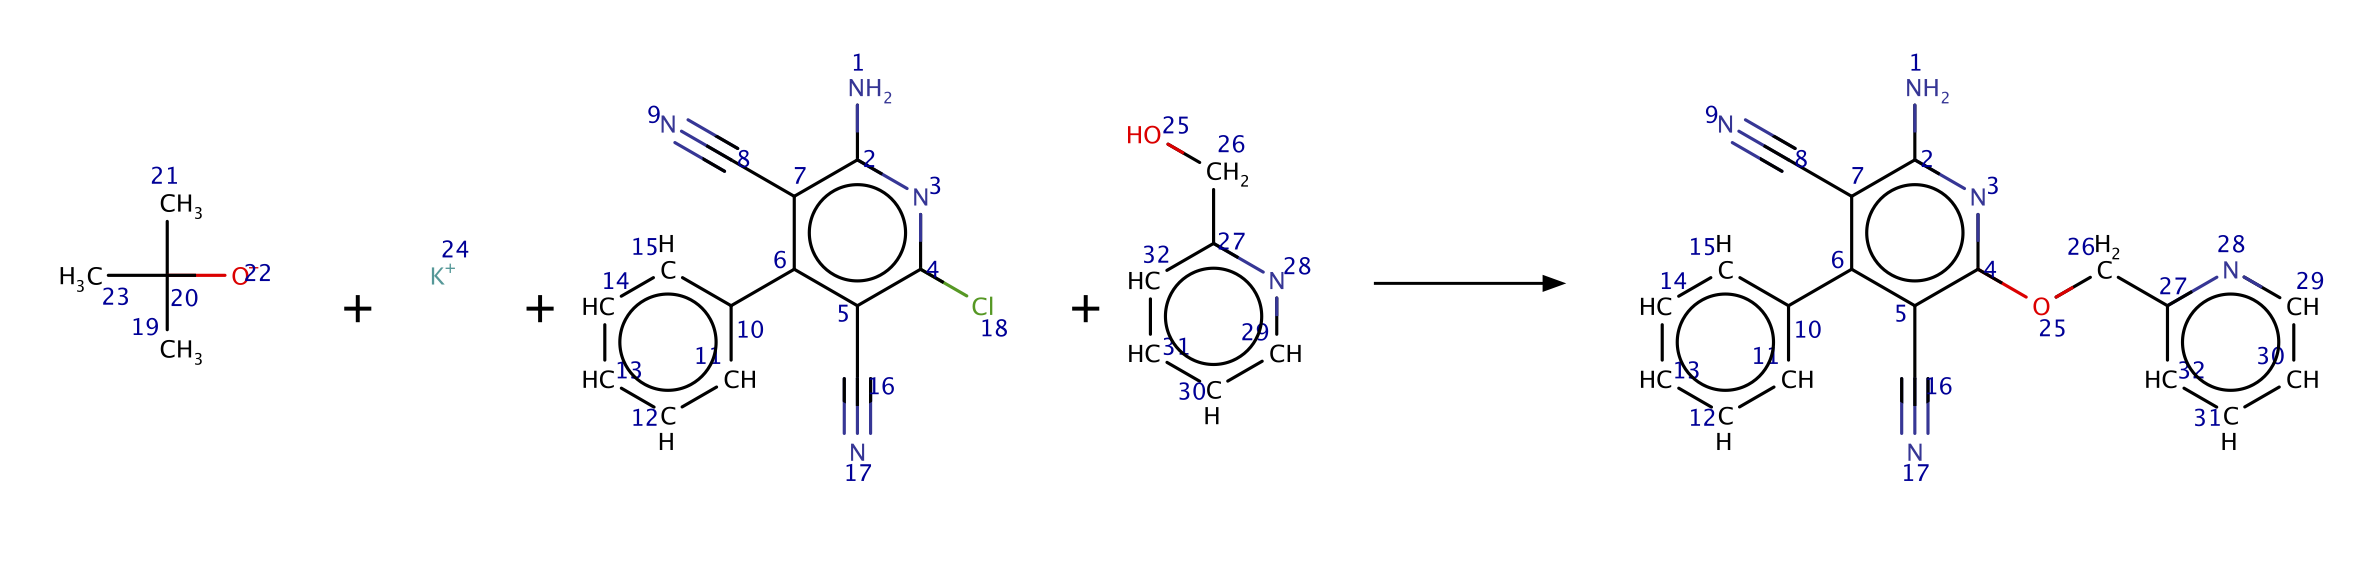

In [6]:
from IPython.display import Image
Image(filename='../imgs/valid_reaction1.png',width=1000, height=800)

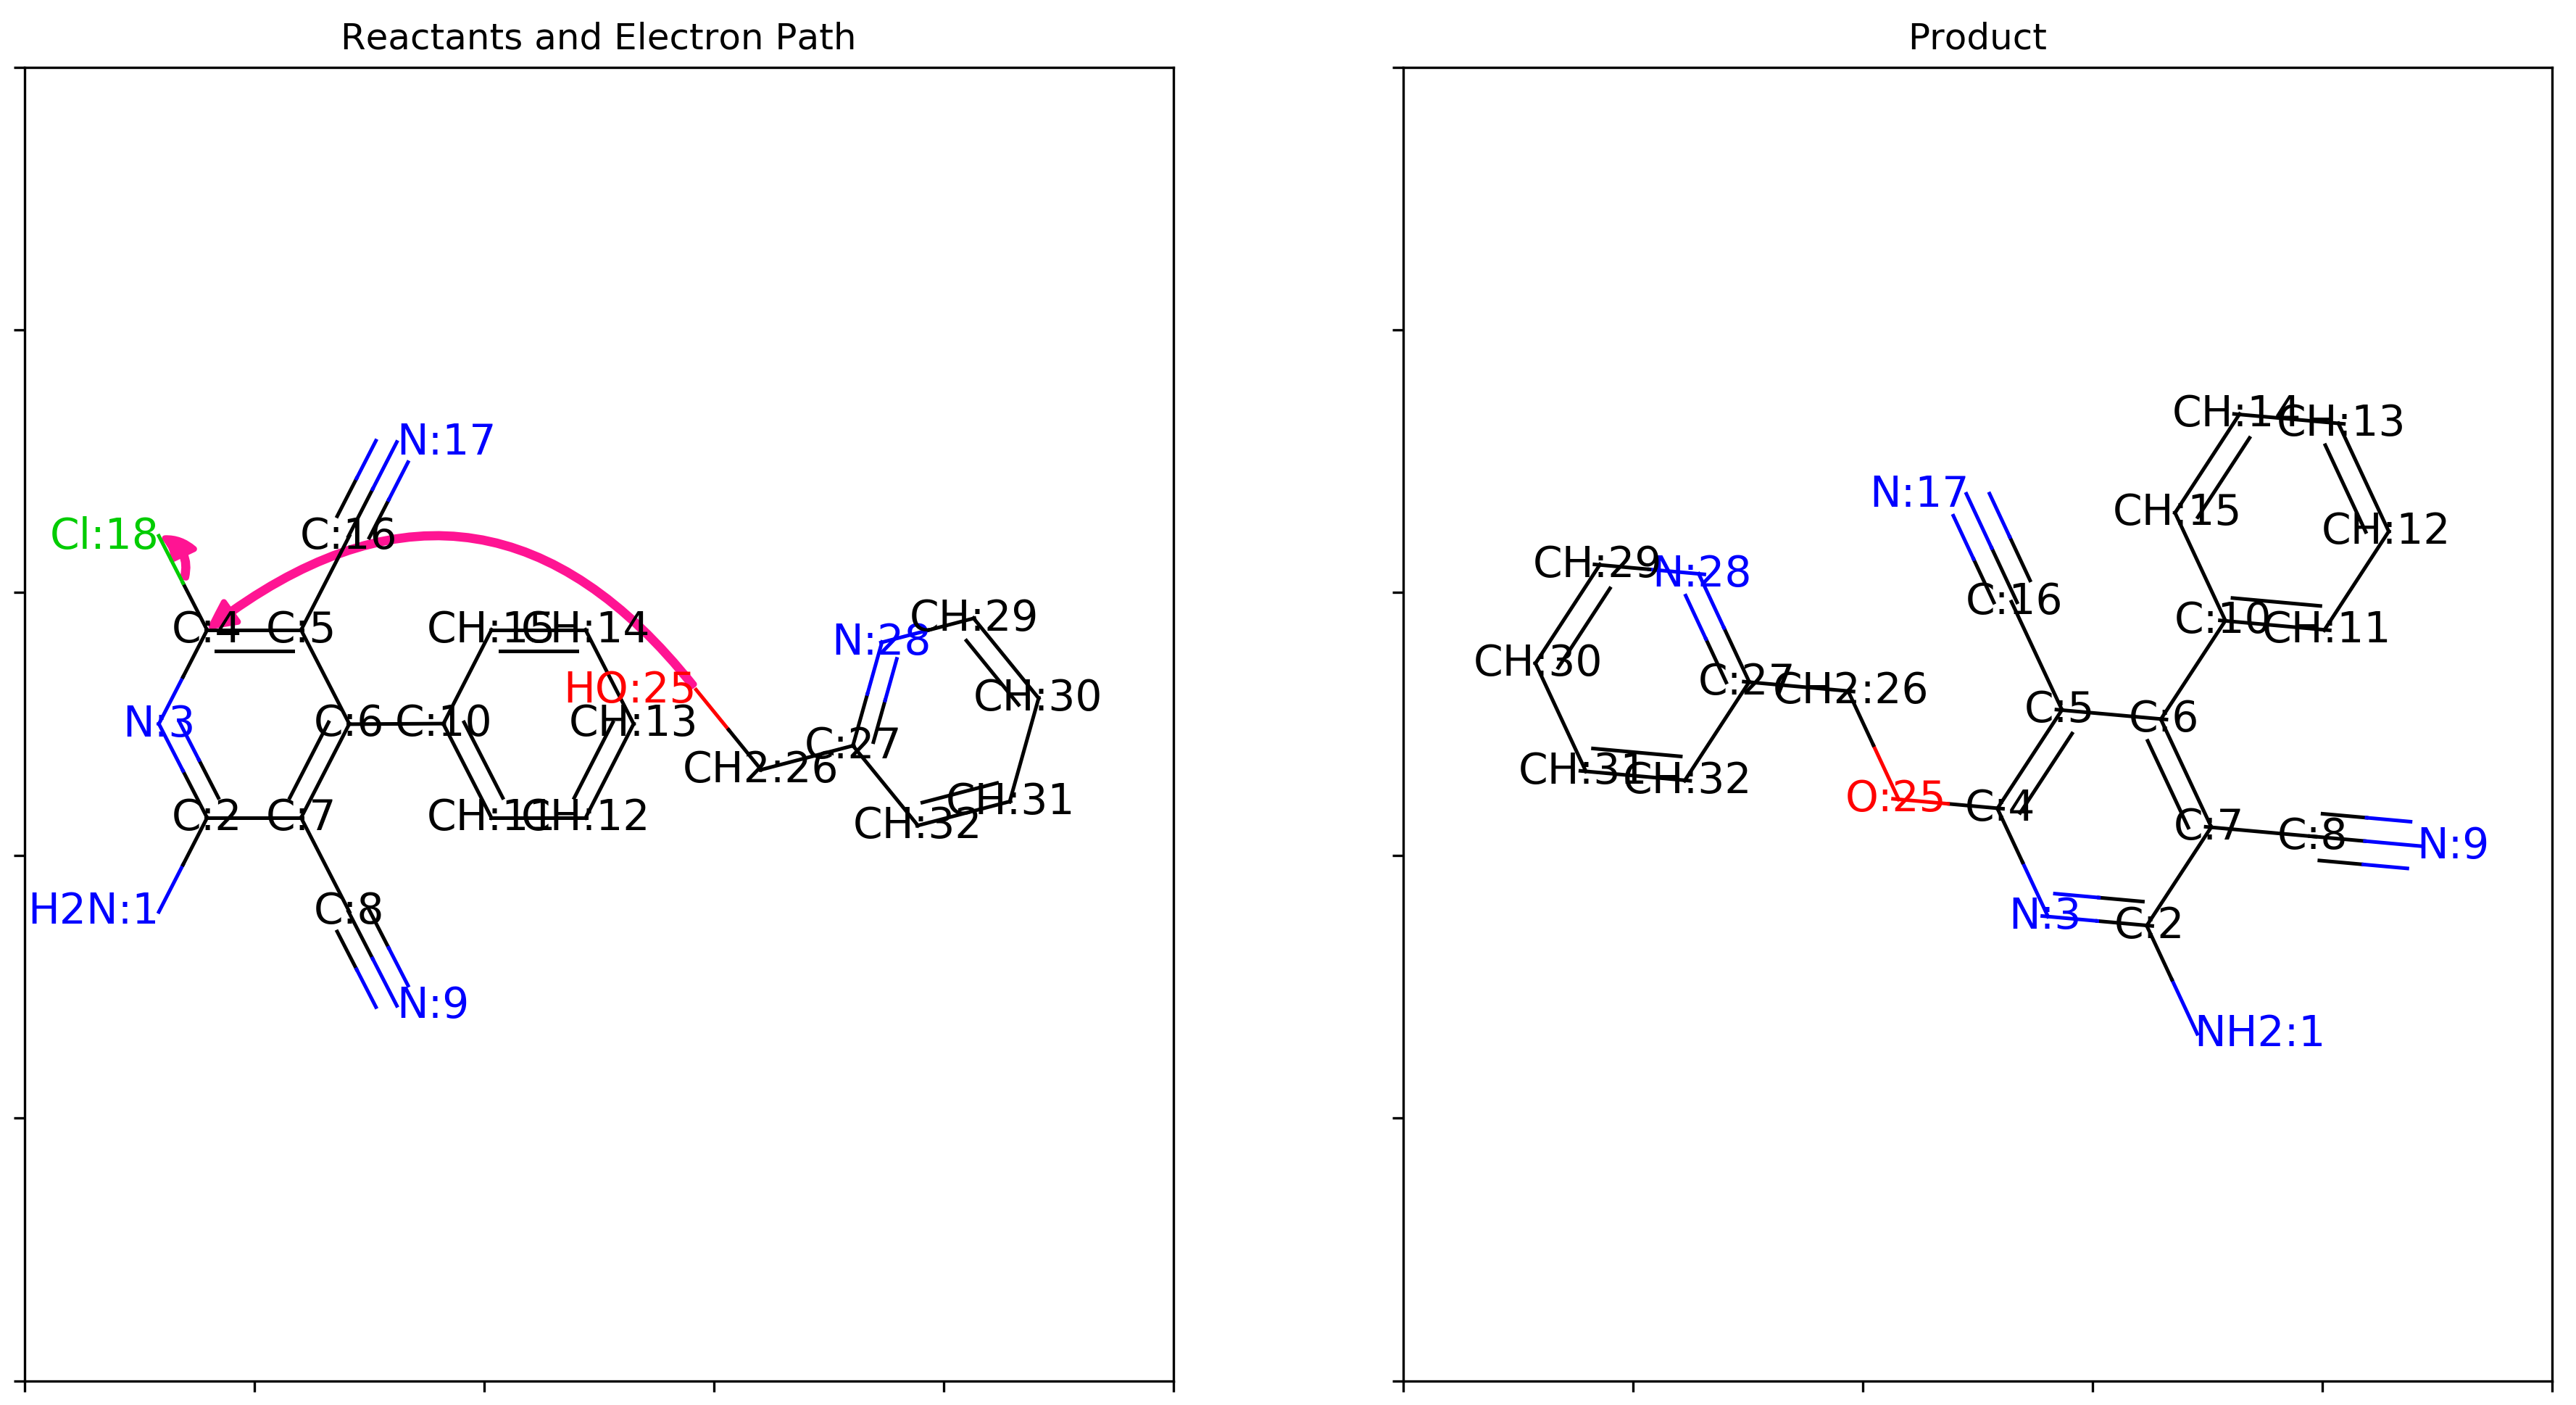

In [7]:
# Item 0
data = dataset[0]
plot_arrow(Chem.MolFromSmiles(data.reactants), Chem.MolFromSmiles(data.products), data.ordered_am_path)

## Item 2 (indx 1)
(nb we are including any reagents in the below plot)

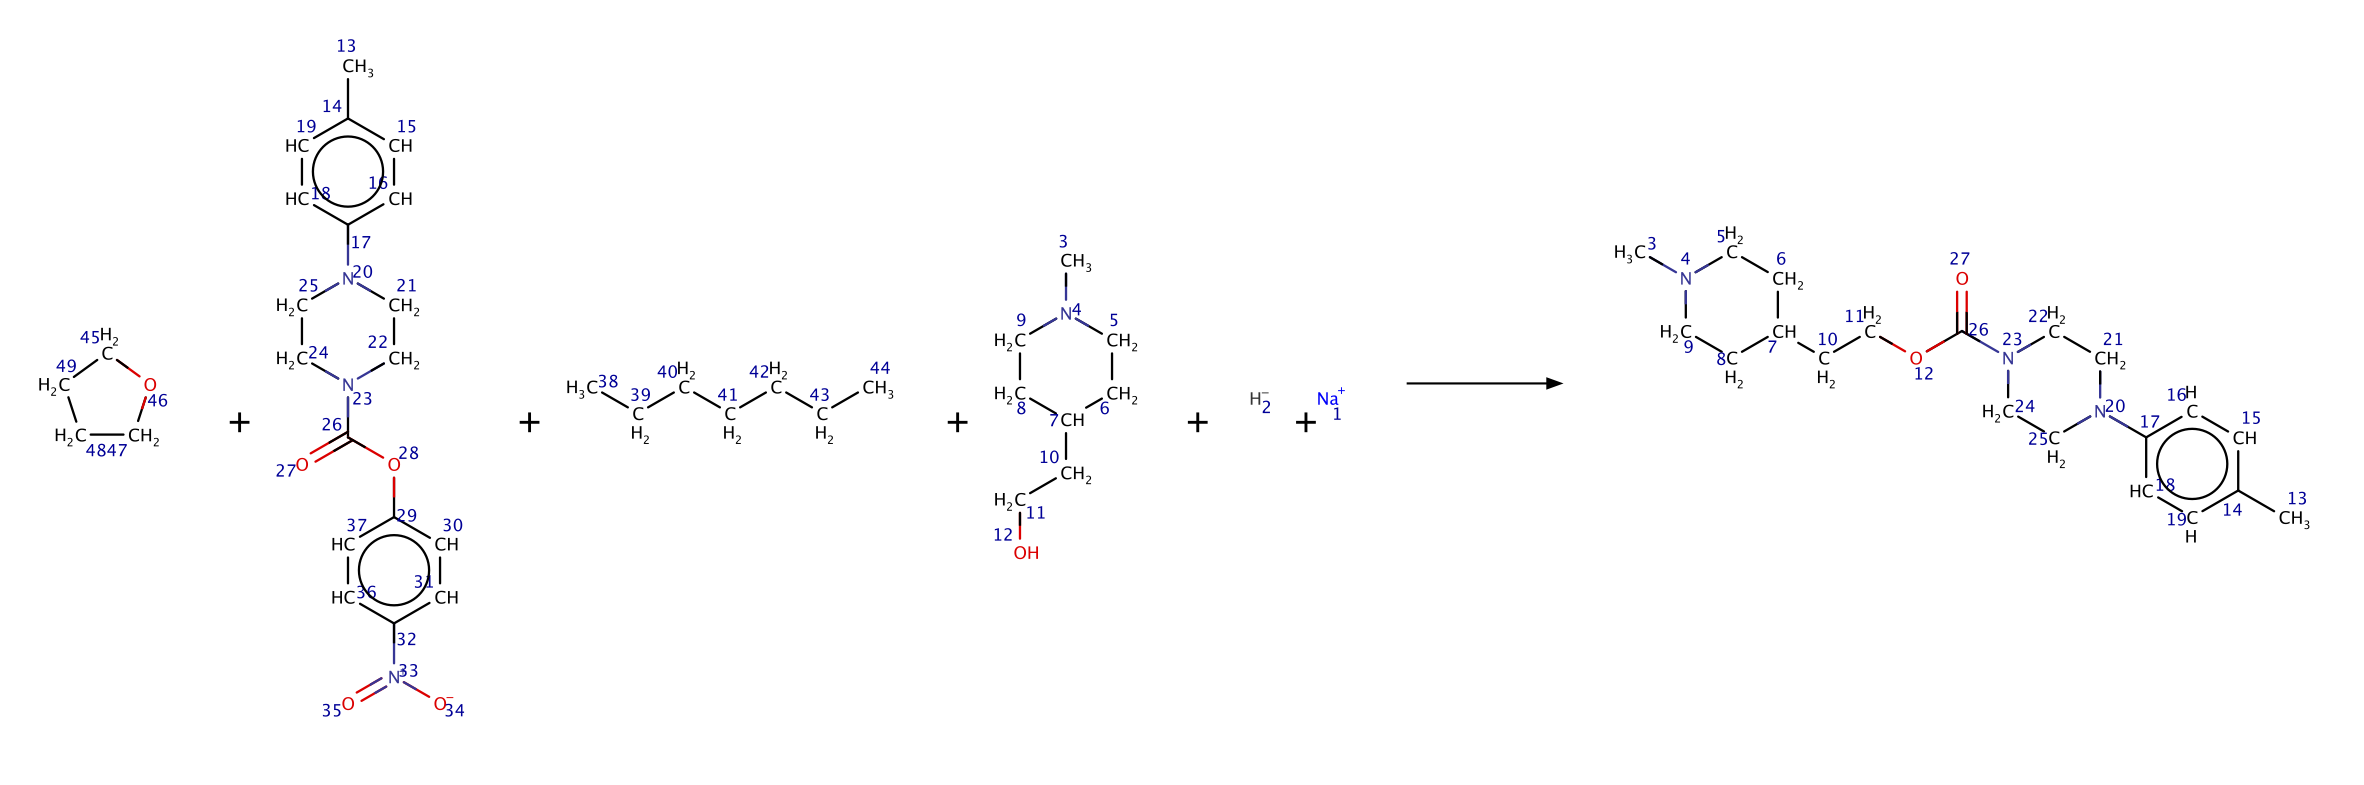

In [8]:
Image(filename='../imgs/valid_reaction2.png',width=1000, height=800)

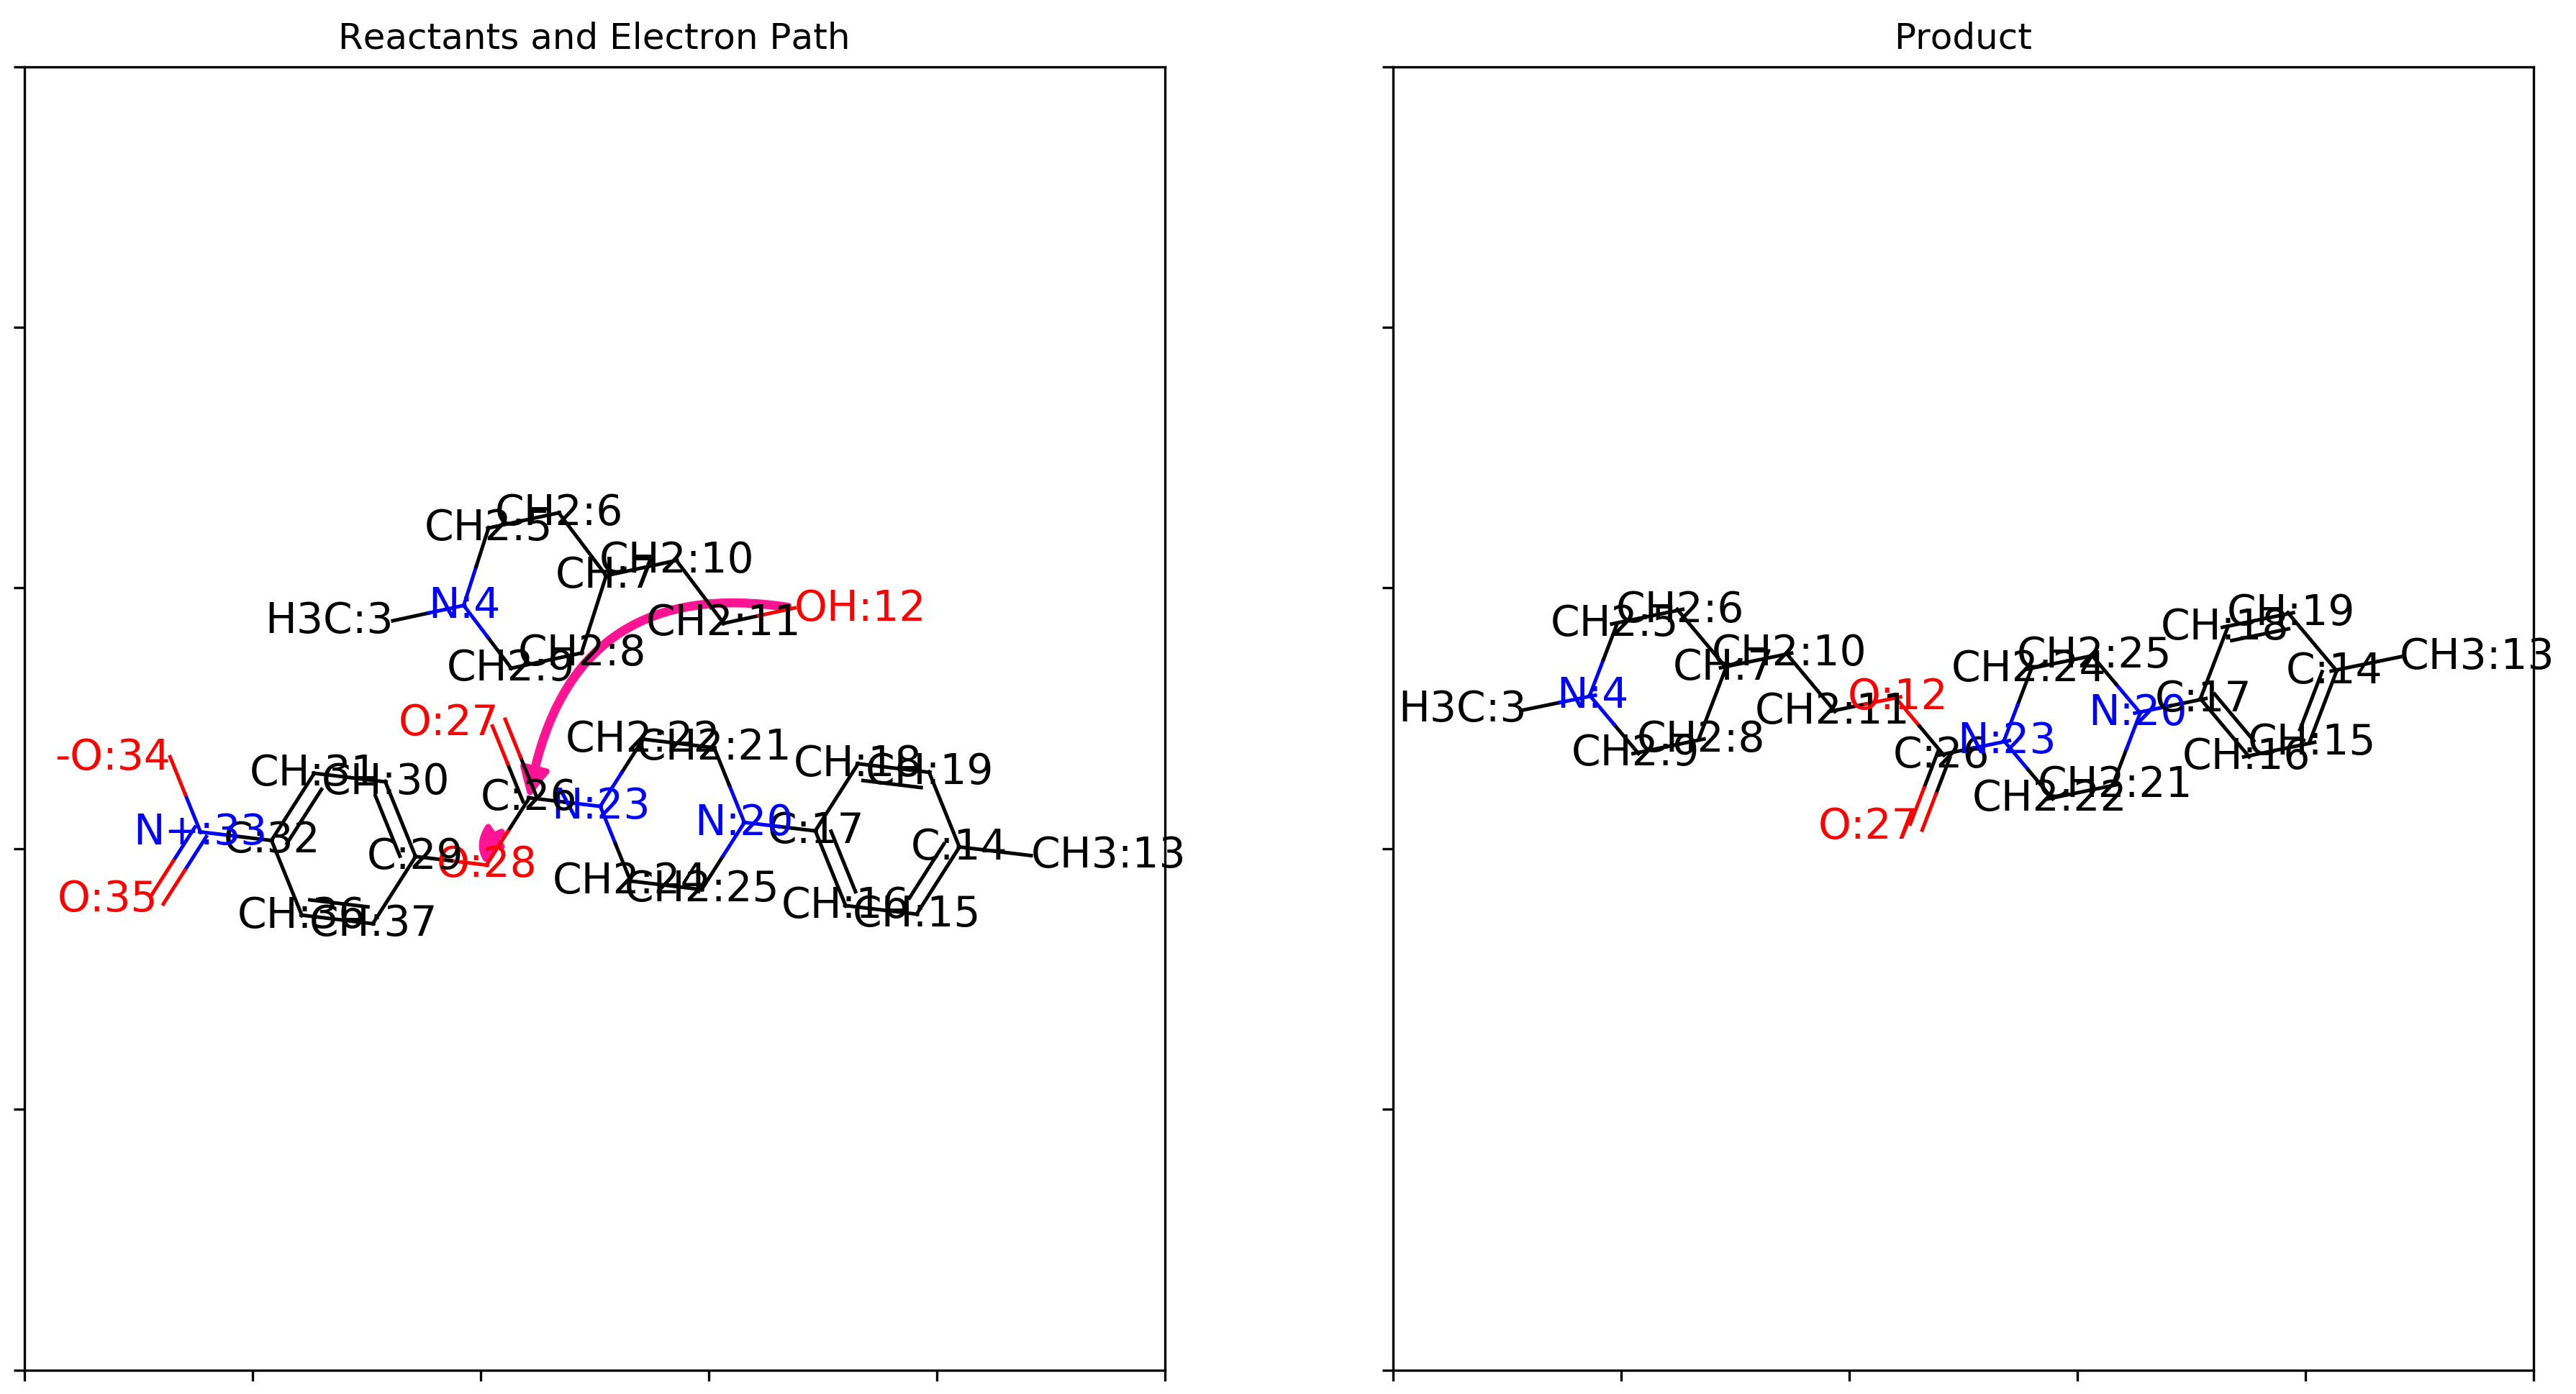

In [9]:
data = dataset[1]
plot_arrow(Chem.MolFromSmiles(data.reactants), Chem.MolFromSmiles(data.products), data.ordered_am_path)

# Looking at ELECTRO-LITE's predictions

We now go on to show how this code can also be used to display the predictions made by ELECTRO-LITE.


In [10]:
import torch

from graph_neural_networks.core import utils

from rxn_steps.model import get_electro
from rxn_steps.predict import beam_searcher


In [11]:
cuda_details = utils.CudaDetails(use_cuda=False)

# Model
variant = get_electro.ElectroVariants.ELECTRO_LITE
full_model = get_electro.get_model(variant, cuda_details=cuda_details)
full_model = cuda_details.return_cudafied(full_model)

# Weights!
checkpoint = torch.load('../scripts/train_electro/chkpts/electrolite.pth.pick', map_location='cpu')
full_model.load_state_dict(checkpoint['state_dict'])

# Beam searcher
predictor = beam_searcher.PredictiveRanking(full_model, cuda_details)


In [12]:
def top_k_predictions(data, predictor, top_k=3):
    fig, axarr = plt.subplots(2, top_k, figsize=(7*top_k,16), dpi=300)
    predicted_result = predictor.predict_out(data.reactants, data.reagents)
    
    molecule_in = Chem.MolFromSmiles(data.reactants)
    AllChem.Compute2DCoords(molecule_in)

    for i in range(top_k):
        act_seq = predicted_result[i]
        actions_am = act_seq.actions_as_am
        product_mol = act_seq.get_intermediate_molecule(len(act_seq))
        prob = act_seq.total_prob

        draw_arrow_pushin(molecule_in, product_mol, actions_am, size=(300, 300), fig=fig, ax=axarr[0, i])
        axarr[0, i].set_title(f"Predicted path choice {i}")
        MolToMPL(product_mol, fig=fig, ax=axarr[1, i])
        axarr[1, i].set_title(f"Resulting product (prob: {np.exp(prob):.4f})")

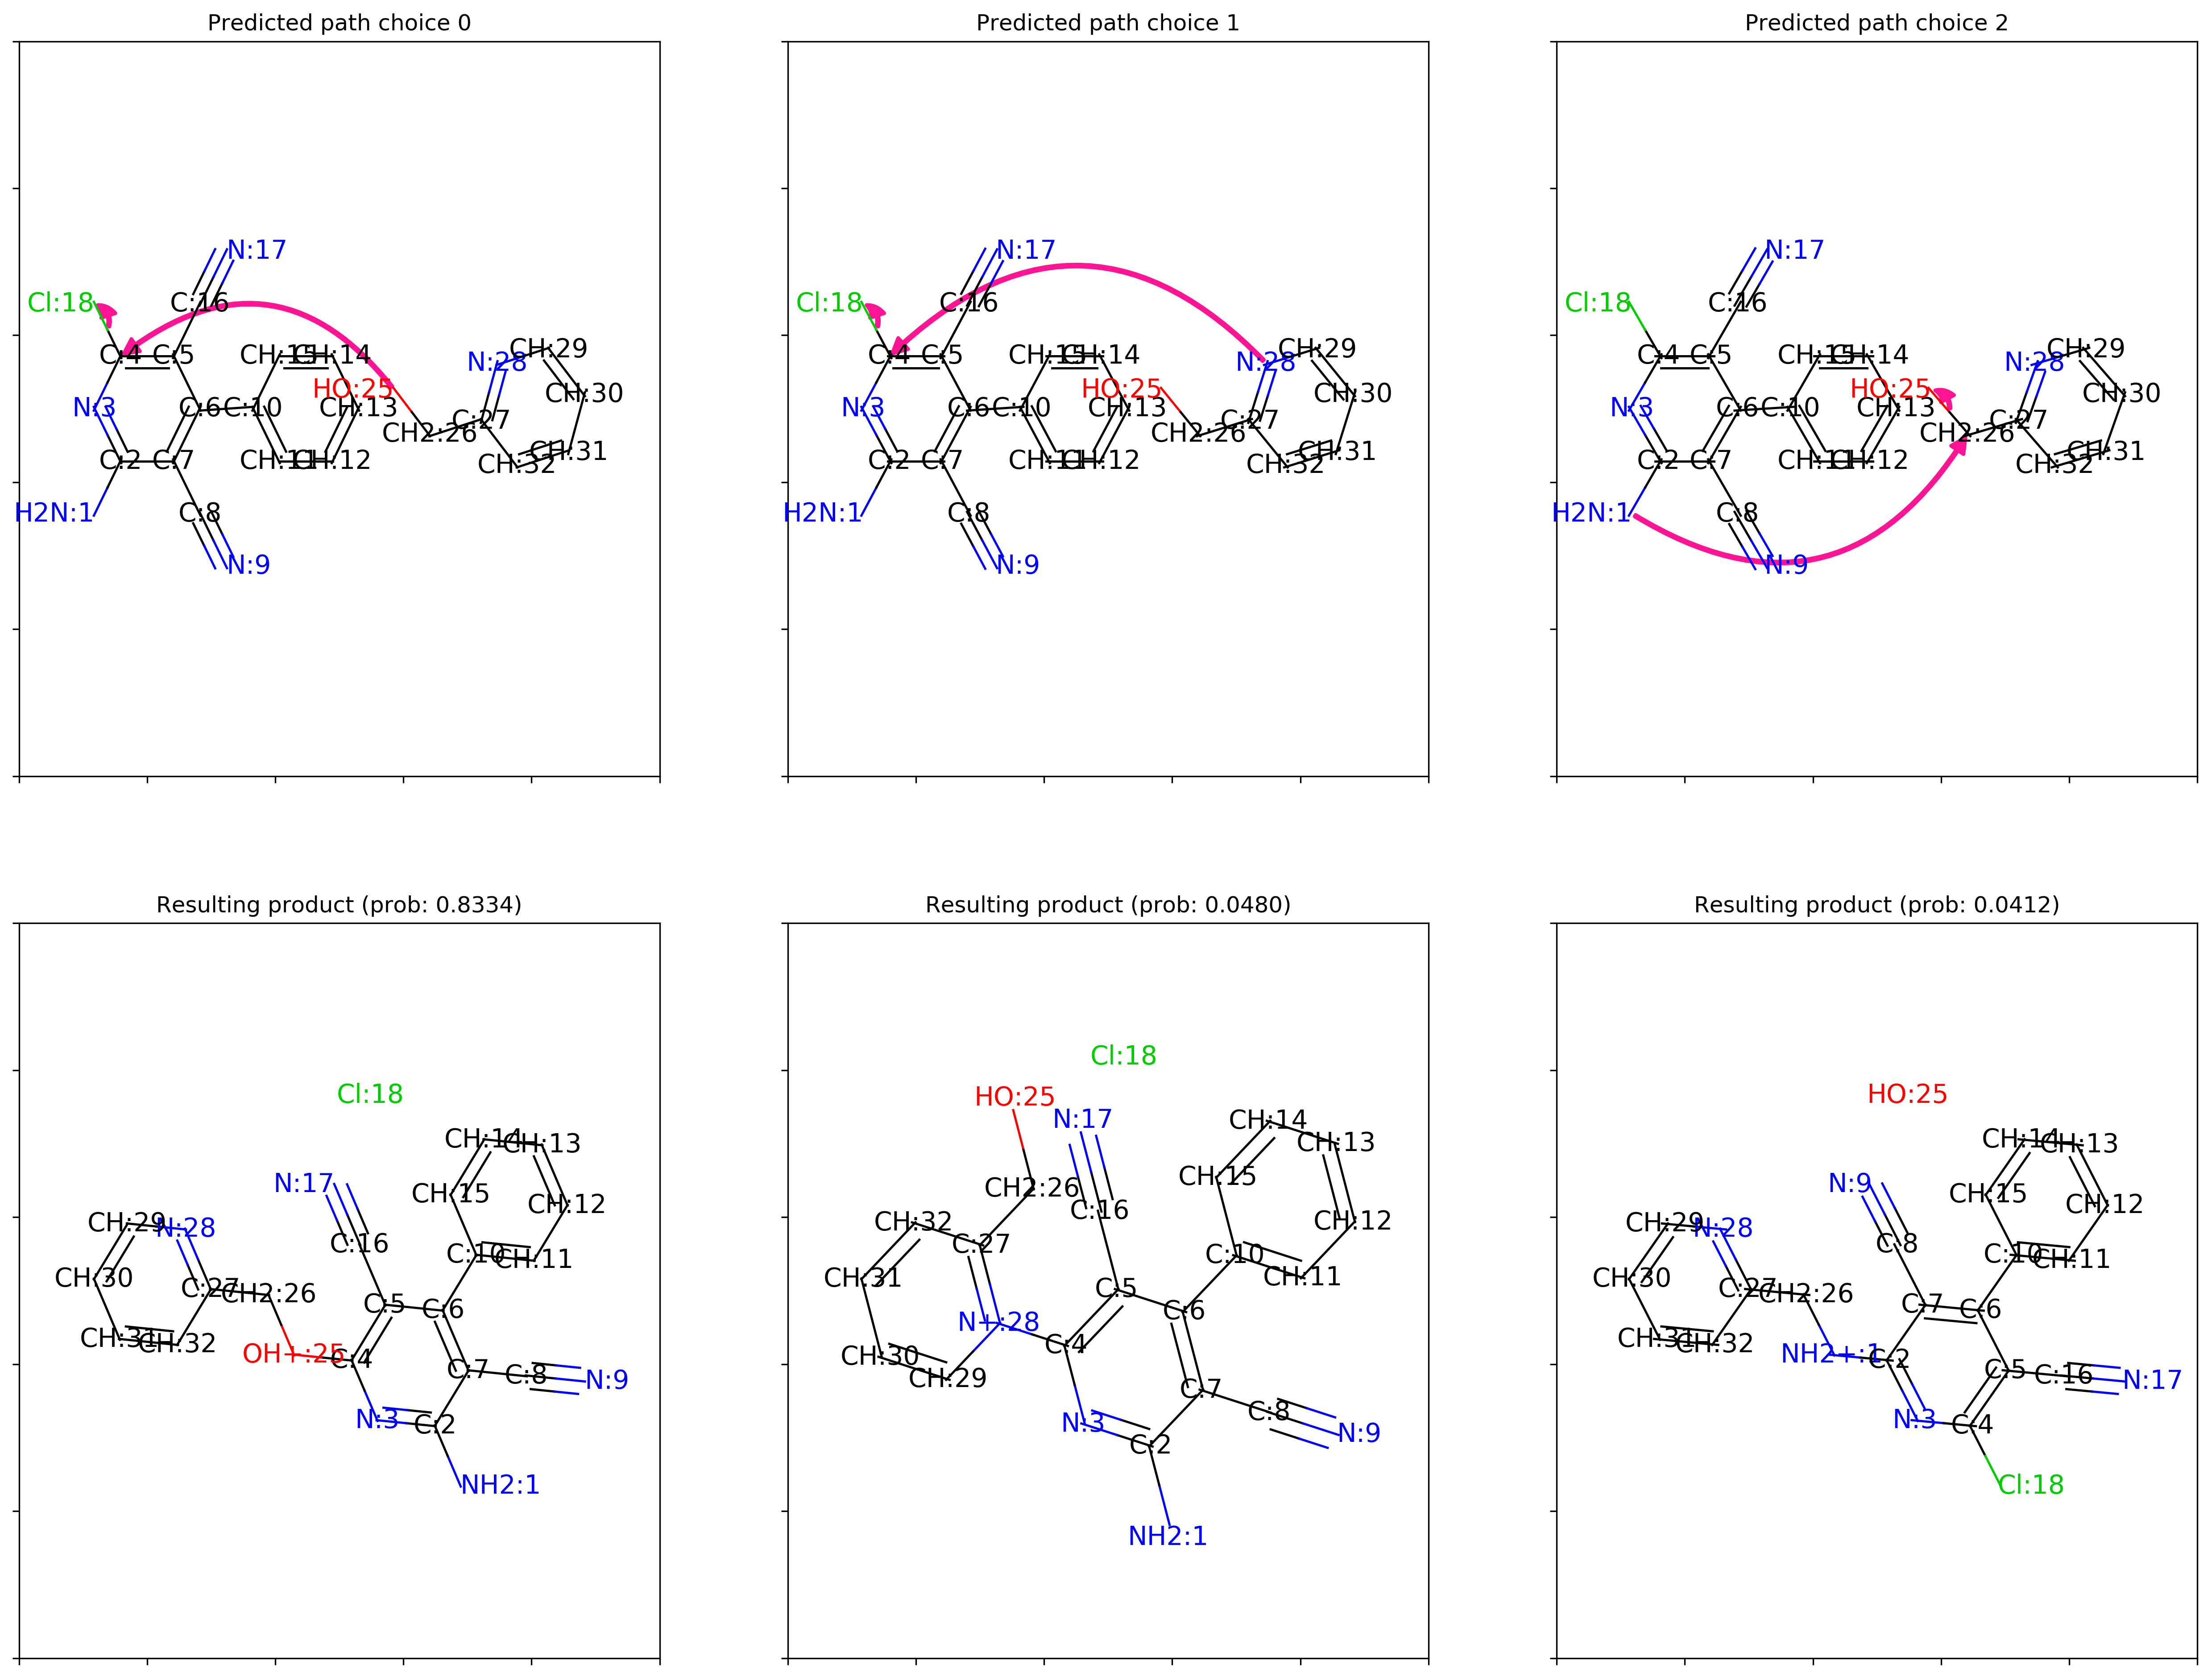

In [13]:
# index 0
data = dataset[0]
top_k_predictions(data, predictor)

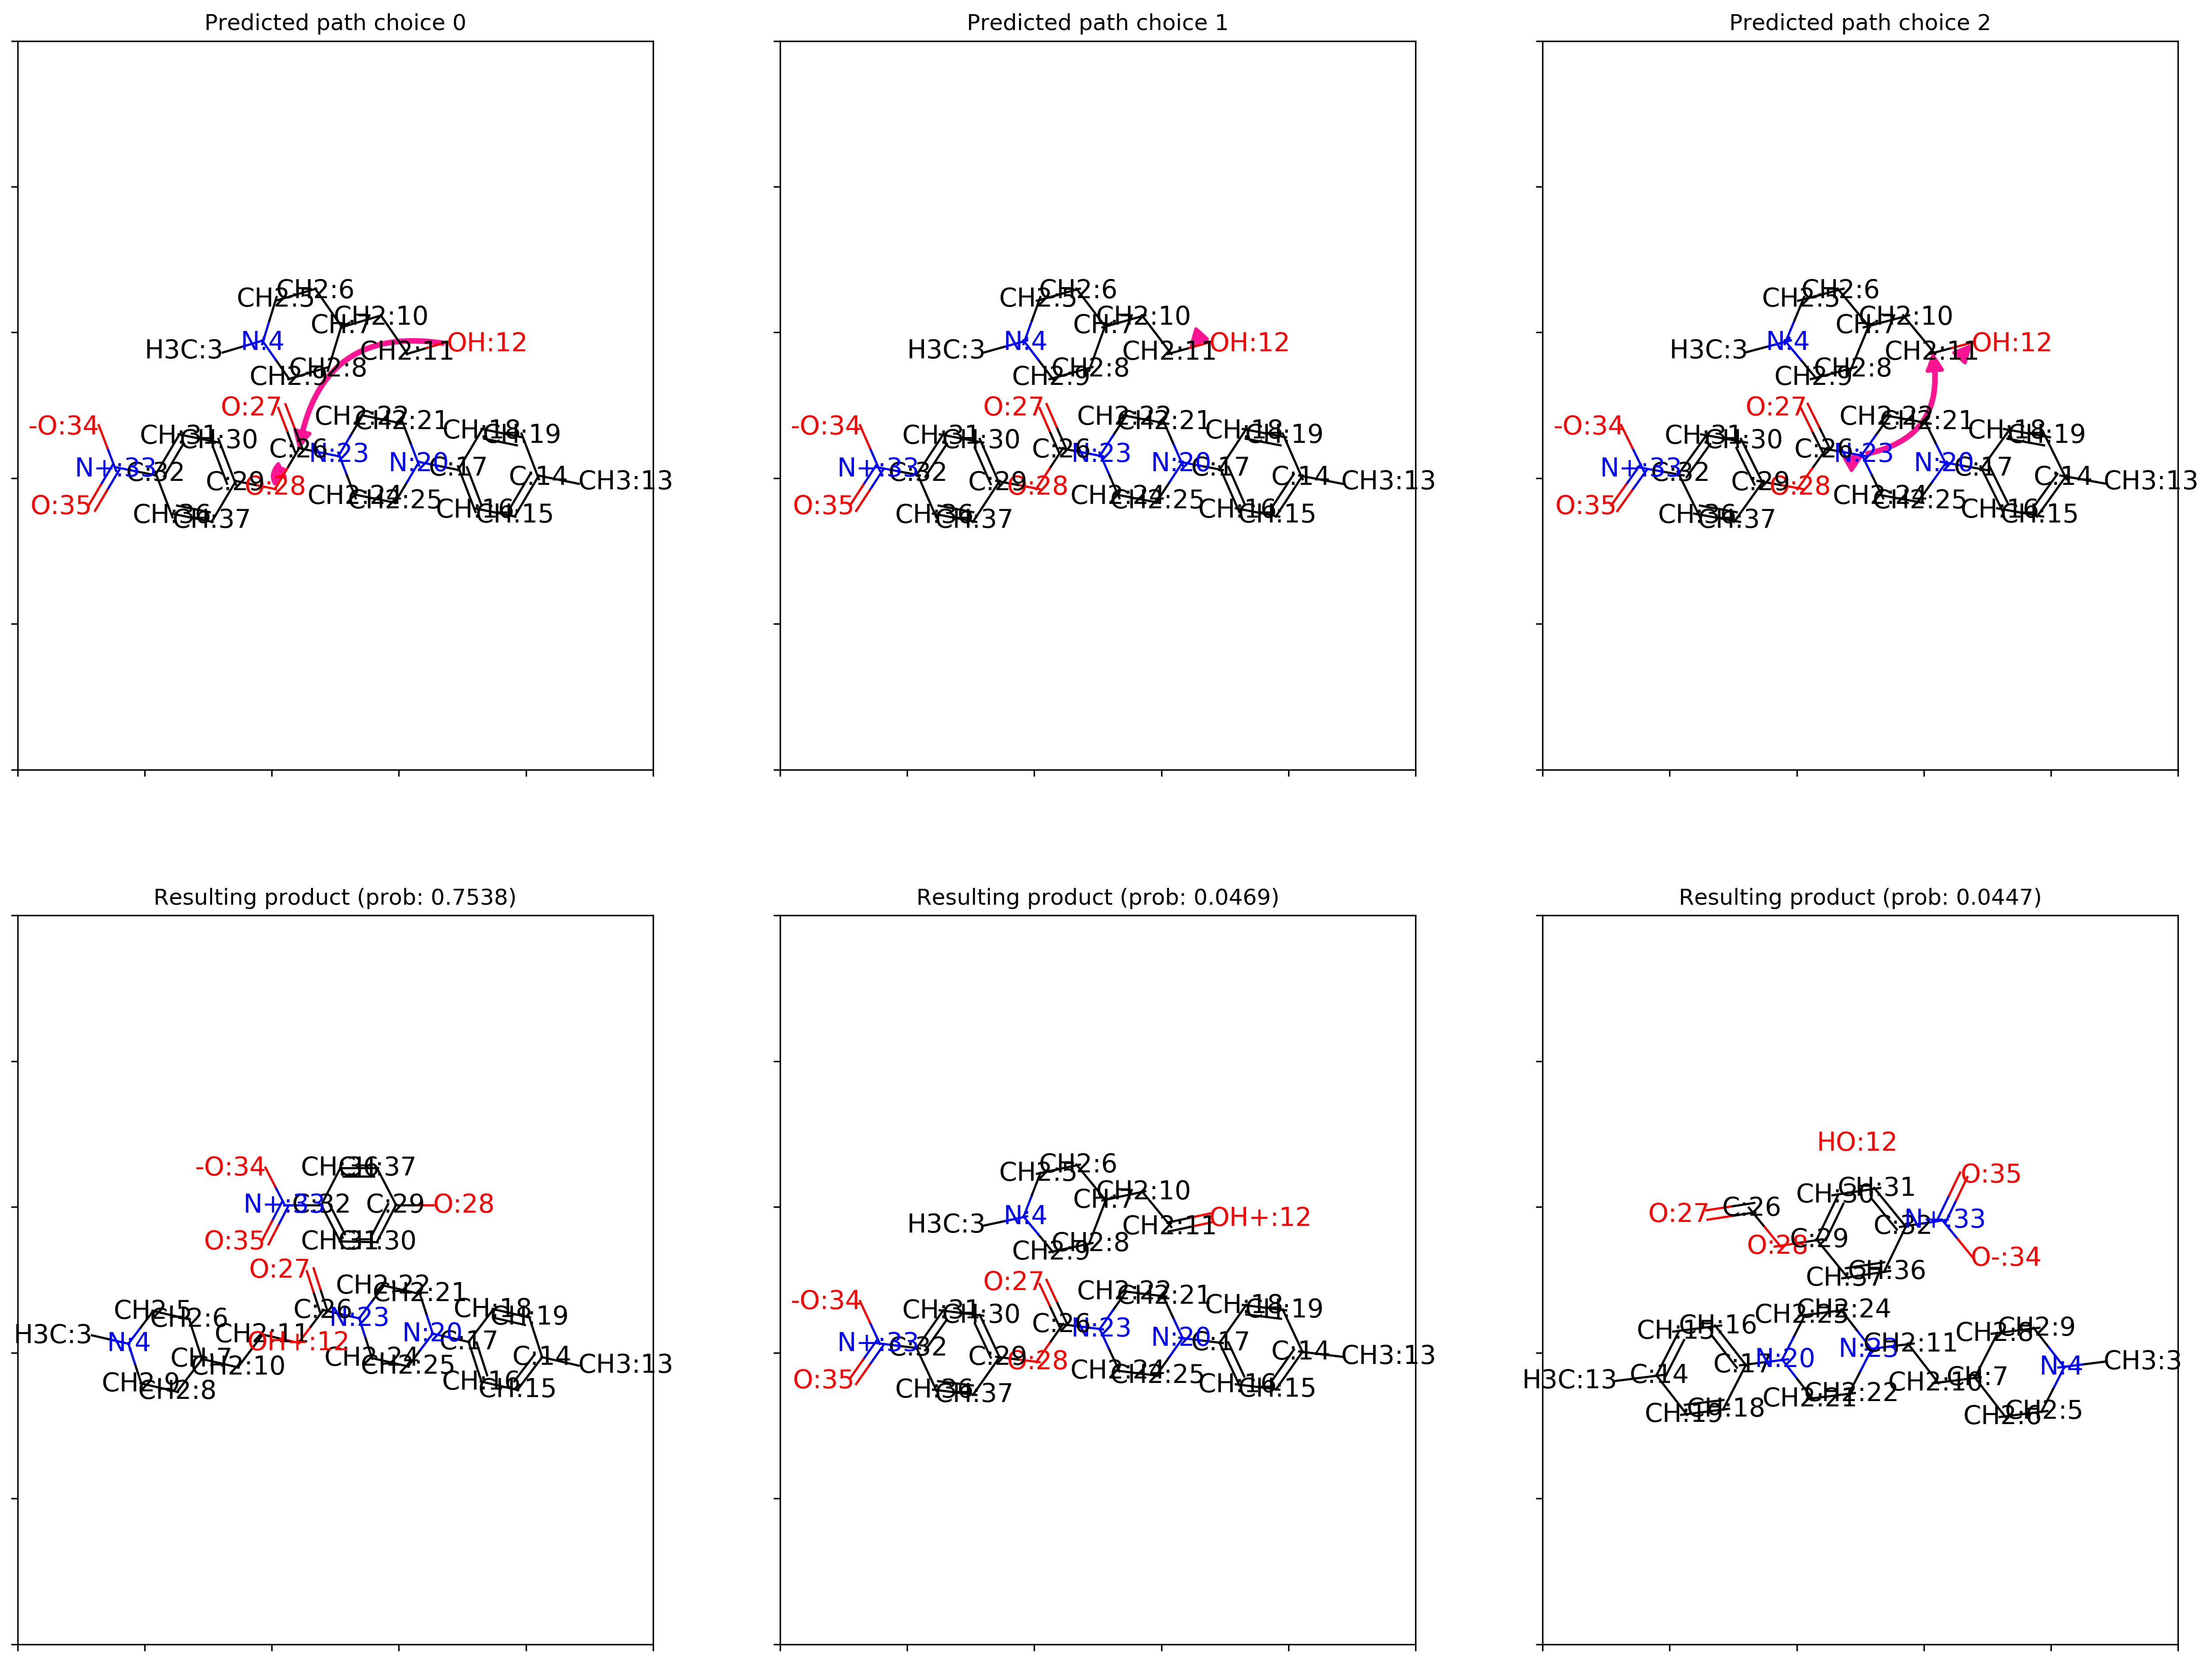

In [14]:
# index 1
data = dataset[1]
top_k_predictions(data, predictor)

In [15]:
# We can also do other reactants....
class NewData:
    def __init__(self, reactants, reagents):
        self.reactants = reactants
        self.reagents = reagents
        self.products = None
        self.ordered_am_path = None
        

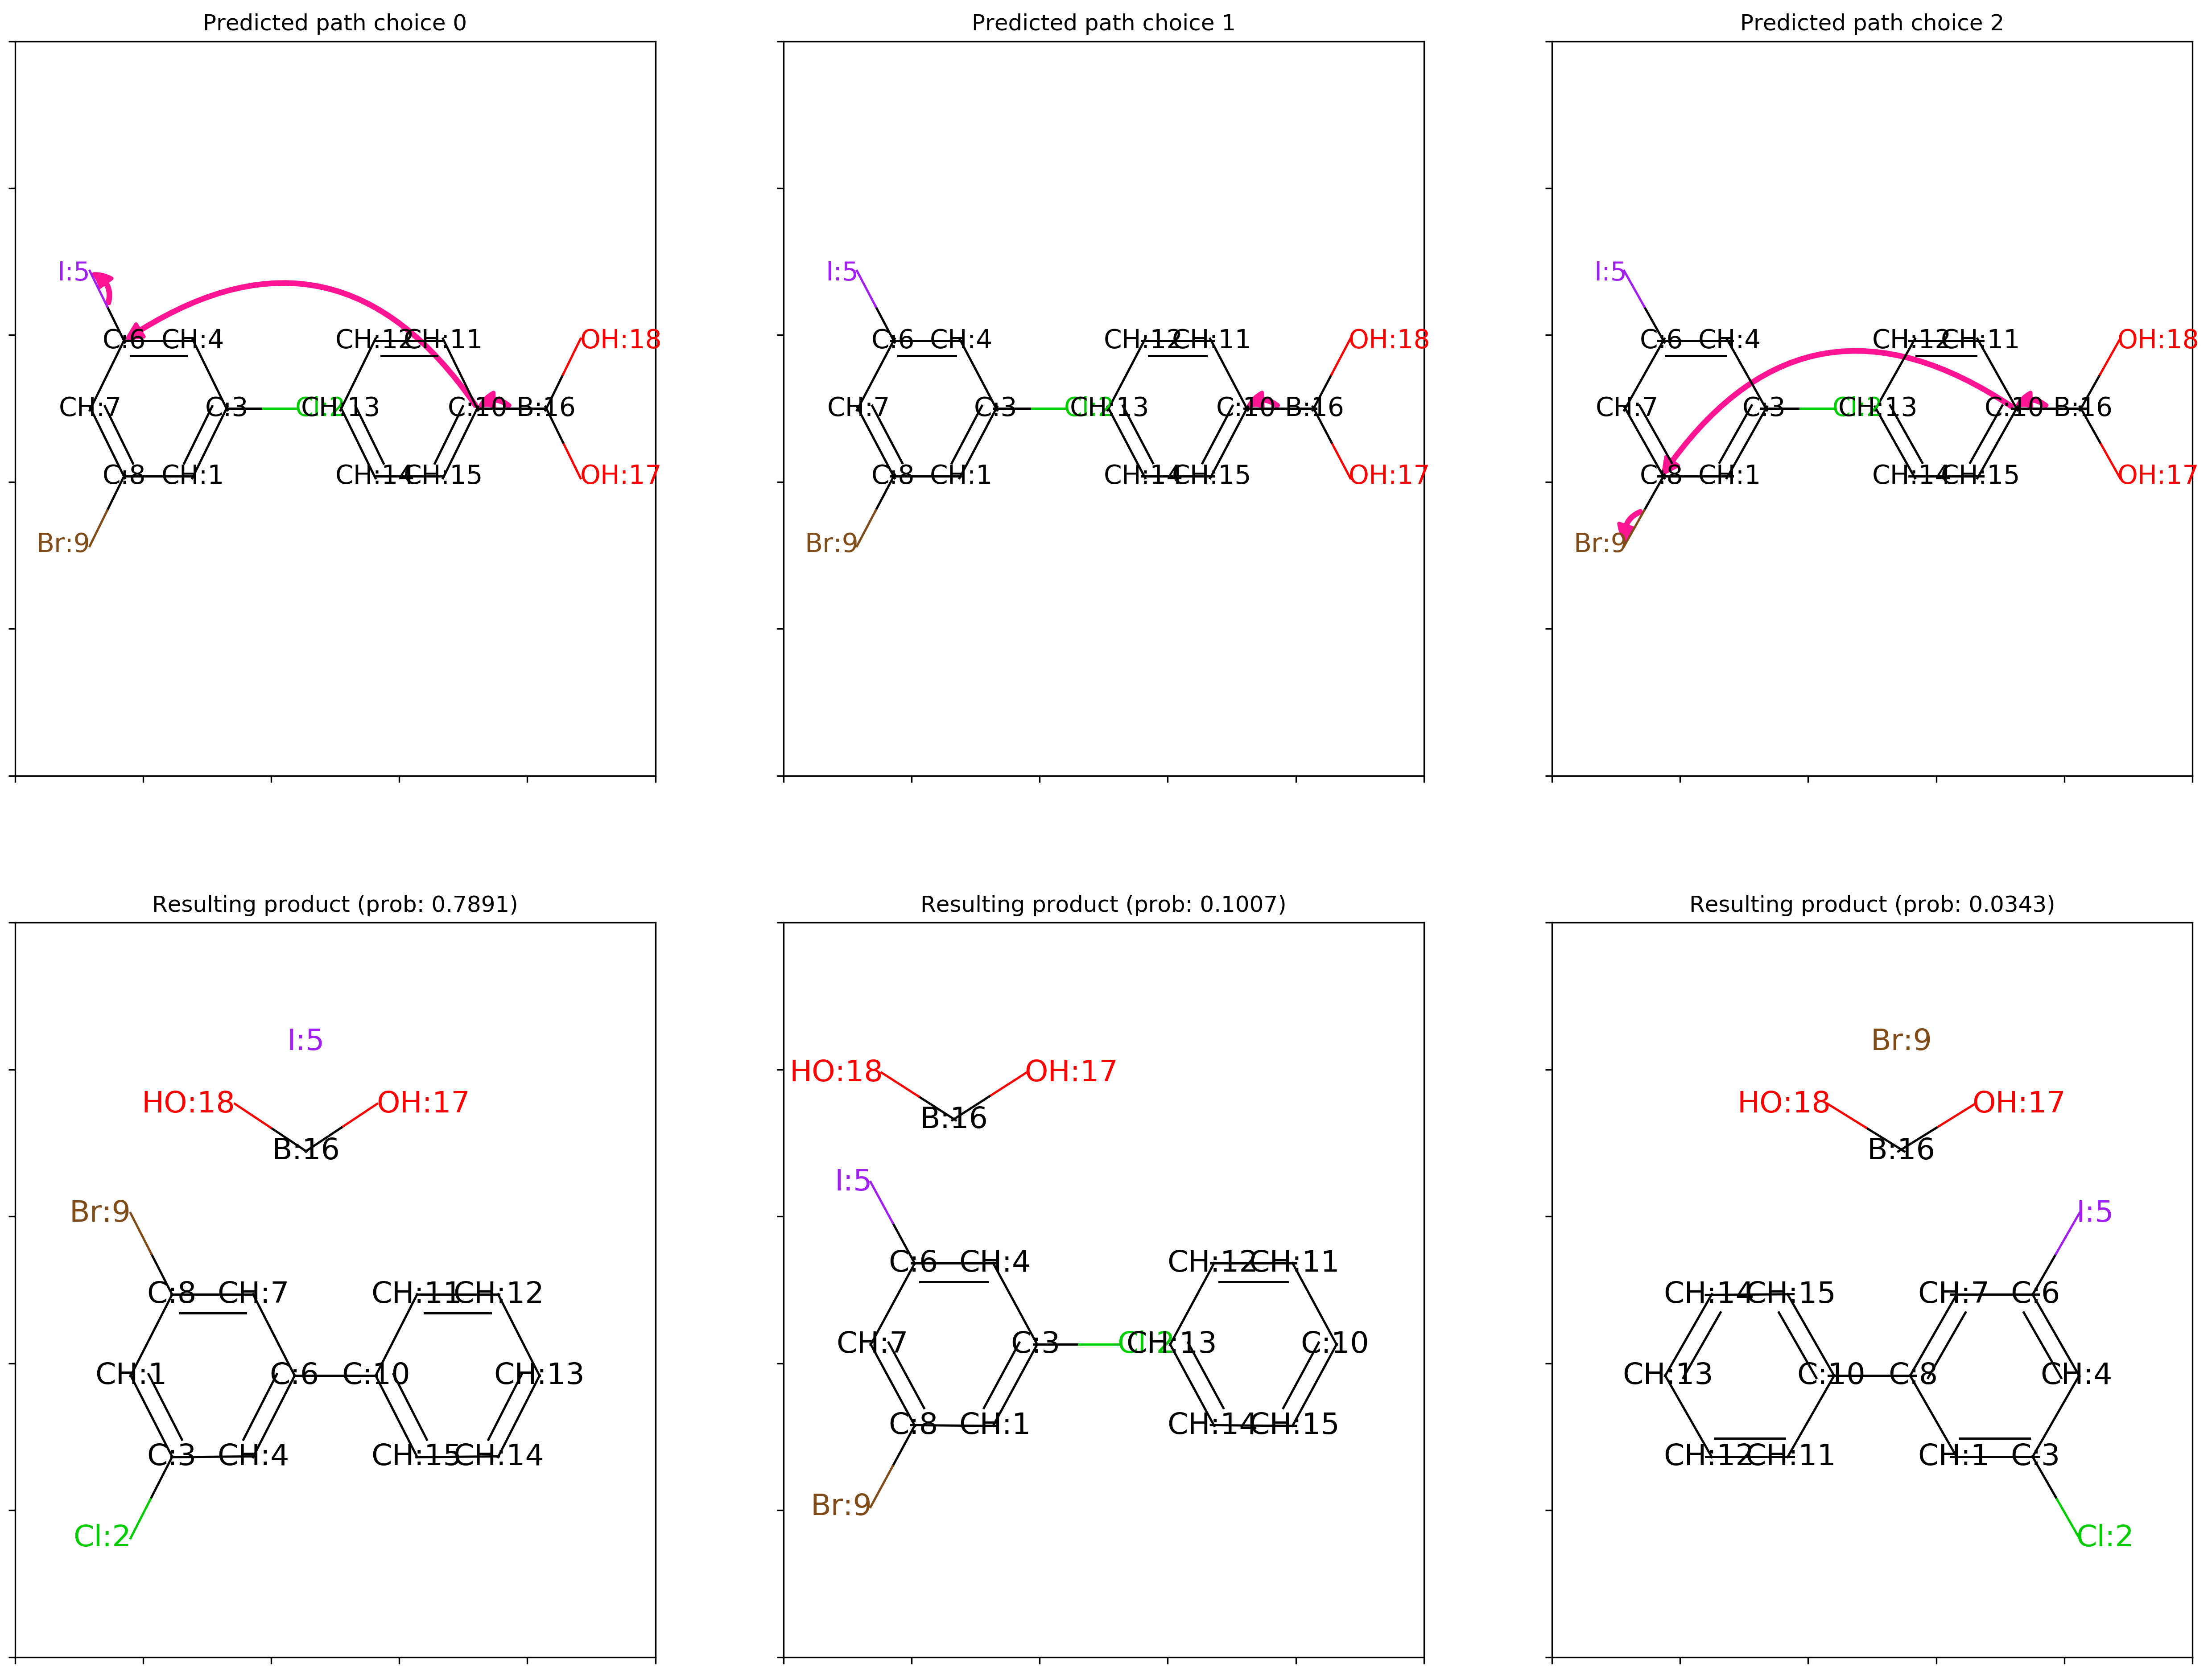

In [16]:
data = NewData('[Cl:2][C:3]1=[CH:1][C:8]([Br:9])=[CH:7][C:6]([I:5])=[CH:4]1.[OH:17][B:16]([OH:18])[C:10]1=[CH:15][CH:14]=[CH:13][CH:12]=[CH:11]1', '')
top_k_predictions(data, predictor)   
# nb the top-2 and top-3 choices are swapped compared to those we showed in the paper, however we are not using the same weights.